In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
tf.__version__

2025-09-05 07:15:12.270704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757056512.435239      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757056512.484339      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.18.0'

In [ ]:
# Retourner ds 1 tableau numpy les pixels de l'image
cat1 = imread('/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train/Acne/07Acne081101.jpeg')
# 
# cat1
cat1.shape  #  shape  => les dimensions
# plt.imshow(cat1)

In [2]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # ✅ luminosité variable
    channel_shift_range=20        # ✅ couleurs différentes
)


# Note that the validation data should not be augmented!
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train",  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=True
)

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        '/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
        
)

Found 13898 images belonging to 22 classes.
Found 1546 images belonging to 22 classes.


In [3]:
# Définir les chemins et les paramètres
TRAIN_DIR = "/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"
TEST_DIR = '/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Créer les datasets à partir des répertoires
# Cette fonction est l'équivalent moderne de flow_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Pas besoin de mélanger les données de validation
)


# 2. Créer un modèle séquentiel pour l'augmentation d'images
# Ces opérations s'exécuteront sur le GPU, en parallèle du modèle.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.2), # rotation_range est en fraction de 2*pi
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    # brightness_range et channel_shift_range peuvent être reproduits
    # avec des fonctions lambda si nécessaire, mais c'est souvent moins critique.
    # Pour le shear, il faut utiliser tf.image.transform
])

AUTOTUNE = tf.data.AUTOTUNE # Laisse TensorFlow choisir le meilleur niveau de parallélisme

# Fonction pour appliquer le pré-traitement
def prepare(ds, augment=False):
    # Redimensionnement et normalisation (rescale)
    rescale = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Appliquer l'augmentation uniquement sur le set d'entraînement
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    # Utiliser le cache pour les petits datasets qui tiennent en mémoire
    # ds = ds.cache() 
    
    # Pré-charger les prochains lots en arrière-plan pendant que le GPU travaille
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds_optimized = prepare(train_dataset, augment=True)
val_ds_optimized = prepare(validation_dataset)

Found 13898 files belonging to 22 classes.


I0000 00:00:1757056545.506055      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1546 files belonging to 22 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models  # models au pluriel, pas model

# Input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3))

# CNN de base
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # <--- inputs ici
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Flatten()(x)


x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)


x = layers.Dropout(0.5)(x)

# Dernière couche pour 22 classes
outputs = layers.Dense(22, activation='softmax')(x)

# Création du modèle
model = models.Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
print("Device du modèle :", tf.config.list_logical_devices('GPU'))
tf.debugging.set_log_device_placement(True)


In [ ]:


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]




history = model.fit(
    train_ds_optimized,
    epochs=25,
    validation_data=val_ds_optimized,
 
    callbacks= callbacks    
    
)


In [ ]:

import tensorflow as tf

print("GPU dispo ? :", tf.test.is_gpu_available())
print("Liste des GPUs :", tf.config.list_physical_devices('GPU'))


 # pretrained

In [33]:
from pprint import pprint
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential #  construire un modèle de type séquence (de couches)
from tensorflow.keras.layers import Dense

from  tensorflow.keras.preprocessing.image import  load_img
from  tensorflow.keras.preprocessing.image import  img_to_array

In [34]:
from  tensorflow.keras.applications.vgg16 import VGG16
modelvg = VGG16()
modelvg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Q : Cmnt accéder aux couches du VGG16 ?
for layer in modelvg.layers:
    print(type(layer))
    print(layer)

len(modelvg.layers)

<class 'keras.src.layers.core.input_layer.InputLayer'>
<InputLayer name=input_layer_18, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block1_conv1, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block1_conv2, built=True>
<class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
<MaxPooling2D name=block1_pool, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block2_conv1, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block2_conv2, built=True>
<class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
<MaxPooling2D name=block2_pool, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block3_conv1, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block3_conv2, built=True>
<class 'keras.src.layers.convolutional.conv2d.Conv2D'>
<Conv2D name=block3_conv3, built=True>
<class 'keras.src.layers.pooli

23

In [36]:
cnn = Sequential()
# cnn.get_config()
for layer in modelvg.layers[:-1]:
    cnn.add(layer)
cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
layer = cnn.layers[0]
layer
layer.count_params() #  1792
layer.get_weights() #  [array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
layer.name #  'block1_conv1'
layer.dtype #  'float32'
layer.input #  <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>
# layer.trainable #  True

for layer in cnn.layers:
    layer.trainable = False

for layer in cnn.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [42]:
cnn.add(Dense(units=22, activation='softmax'))

In [43]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn.fit(
    train_ds_optimized,
    steps_per_epoch=len(train_ds_optimized),
    epochs=30,
    validation_data=val_ds_optimized,
    validation_steps=len(val_ds_optimized),
)

# test autre

In [6]:


train_path="/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train"
test_path="/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test"

IMG_SIZE = 224
batch_size = 32

In [7]:
def cnn_preprocess(x):
    return x/255.0

In [8]:
# Percentage split train /val data
train_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=cnn_preprocess,
    validation_split=0.2
)

In [9]:


# Train Data load 
train_generator = train_val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)



Found 11128 images belonging to 22 classes.


In [10]:
# Validation Data load 
val_generator = train_val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2770 images belonging to 22 classes.


In [11]:


## Test Data load 
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=cnn_preprocess)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 1546 images belonging to 22 classes.


In [14]:


cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),

    tf.keras.layers.Dense(units=22, activation='softmax', dtype='float32')
])



In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models  # models au pluriel, pas model

# Input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3))





# CNN de base
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # <--- inputs ici
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)


x = layers.Dense(128, activation='relu')(x)



# Dernière couche pour 22 classes
outputs = layers.Dense(22, activation='softmax')(x)

# Création du modèle
cnn_model = models.Model(inputs=inputs, outputs=outputs)

# Compilation
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,065,686 (99.43 MB)

 Trainable params: 26,064,790 (99.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [20]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')
])

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [29]:
cnn_history = cnn_model.fit(
        train_generator,
        epochs = 20,
        validation_data = val_generator,
        callbacks = callbacks
        )

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1180 - loss: 2.9811 - precision: 0.2328 - recall: 2.3773e-05
Epoch 1: val_loss did not improve from 2.51134
348/348 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.1180 - loss: 2.9811 - precision: 0.2350 - recall: 2.3962e-05 - val_accuracy: 0.1191 - val_loss: 2.9774 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.1180 - loss: 2.9779 - precision: 0.8103 - recall: 1.4880e-04
Epoch 2: val_loss did not improve from 2.51134
348/348 ━━━━━━━━━━━━━━━━━━━━ 79s 228ms/step - accuracy: 0.1180 - loss: 2.9779 - precision: 0.8109 - recall: 1.4863e-04 - val_accuracy: 0.1191 - val_loss: 2.9774 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1225 - loss: 2.9769 - precision: 0.0431 - recall: 3.9536e-06
Epoch 3: val_loss did not improve from 2.51134
348/348 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step 

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models  # models au pluriel, pas model

# Input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3))





# CNN de base
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # <--- inputs ici
x= layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x= layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)


x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Dernière couche pour 22 classes
outputs = layers.Dense(22, activation='softmax')(x)

# Création du modèle
cnn_model_2 = models.Model(inputs=inputs, outputs=outputs)

# Compilation
cnn_model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model_2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,070 (1.63 MB)

 Trainable params: 425,110 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [35]:
cnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')
])

In [36]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [38]:
cnn_history_2 = cnn_model_2.fit(
        train_generator,
        epochs = 20,
        validation_data = val_generator,
        callbacks = callbacks
        )

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.2395 - loss: 2.4970 - precision: 0.6899 - recall: 0.0851
Epoch 1: val_loss improved from 3.49821 to 2.60350, saving model to CNN_best_model.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.2395 - loss: 2.4970 - precision: 0.6899 - recall: 0.0851 - val_accuracy: 0.2267 - val_loss: 2.6035 - val_precision: 0.8000 - val_recall: 0.0708
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2524 - loss: 2.4522 - precision: 0.7213 - recall: 0.0974
Epoch 2: val_loss did not improve from 2.60350
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy: 0.2524 - loss: 2.4521 - precision: 0.7213 - recall: 0.0974 - val_accuracy: 0.1296 - val_loss: 4.5023 - val_precision: 0.4937 - val_recall: 0.0848
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2723 - loss: 2.3636 - precision: 0.7327 - recall: 0.0999
Epoch 3: val_loss did not improve from 2.60350
348/348 ━━━━━━━━━━━━━━━━━━━━ 72s 206ms

In [39]:
cnn_model_2.save('/kaggle/working/model2.h5')

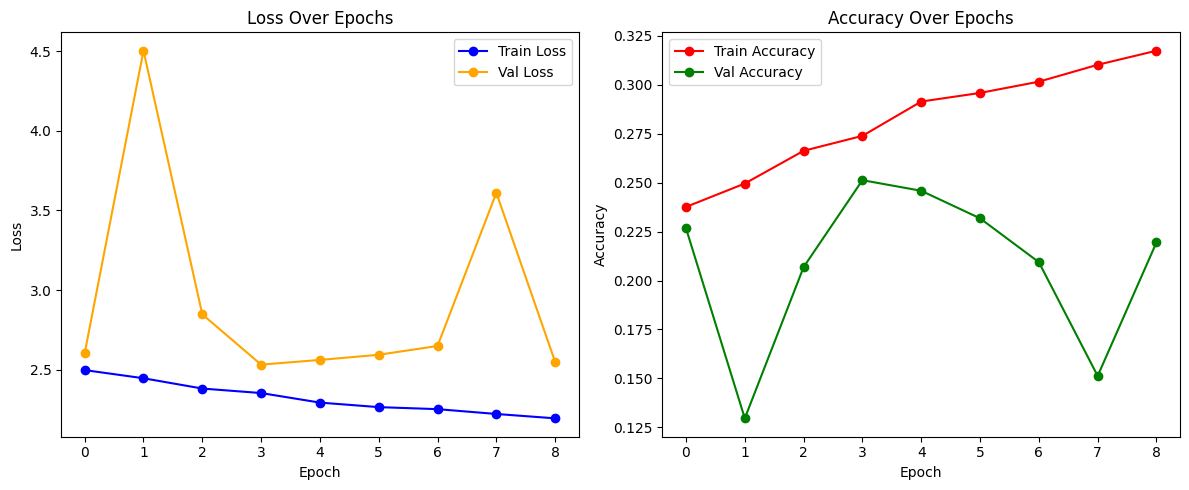

In [40]:


# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history_2.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history_2.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history_2.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history_2.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



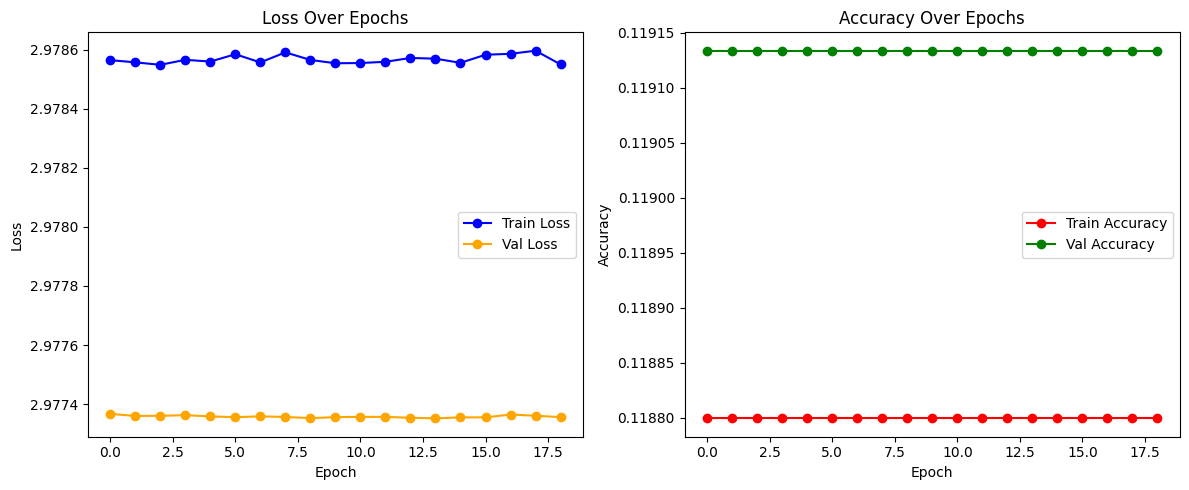

In [41]:


# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

